In [ ]:

import joblib
import os


from sklearn.preprocessing import StandardScaler


from sklearn.model_selection import GridSearchCV


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import (
    AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier,
    RandomForestClassifier
)
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

import lightgbm as lgb
import xgboost as xgb
from xgboost import plot_importance



import matplotlib.pyplot as plt

from tqdm import tqdm

from utils import (
    evaluate_model, extract_features, format_model_metrics,
    import_data, plot_confusion_matrix, plot_precision_recall_curves,
    plot_roc_curves
)


In [2]:
imported_data = import_data(16)
X, y, (X_train, X_test, y_train, y_test) = extract_features(imported_data, return_ml_ready=True)

100%|██████████| 21276/21276 [01:48<00:00, 196.68it/s]


In [ ]:
def perform_and_return_grid_search(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=4, n_jobs=-1, verbose=10)
    grid_search.fit(X_train, y_train)
    return grid_search

if not os.path.exists("grids"):
    os.makedirs("grids")


pipeline_qda = Pipeline([
    ('scaler', StandardScaler()),
    ('qda', QuadraticDiscriminantAnalysis())
])
param_grid_qda = {
    'qda__reg_param': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9, 0.99],
    'qda__store_covariance': [True, False],
    'qda__tol': [1e-4, 1e-5, 1e-6],
}
fitted_grid_search_qda = perform_and_return_grid_search(pipeline_qda, param_grid_qda, X_train, y_train)
joblib.dump(fitted_grid_search_qda,"./grids/qda_grid.pkl")


pipeline_logreg = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=3000))
])

param_grid_logreg = [
    {
        'logreg__C': [0.1, 1, 10, 100],
        'logreg__penalty': ['l1'],
        'logreg__solver': ['liblinear', 'saga'],
    },
    {
        'logreg__C': [0.1, 1, 10, 100],
        'logreg__penalty': ['l2'],
        'logreg__solver': ['liblinear', 'saga'],
    },
    {
        'logreg__C': [0.1, 1, 10, 100],
        'logreg__penalty': ['elasticnet'],
        'logreg__solver': ['saga'],
        'logreg__l1_ratio': [0.1, 0.5, 0.9]
    }
]
fitted_grid_search_logreg = perform_and_return_grid_search(pipeline_logreg, param_grid_logreg, X_train, y_train)
joblib.dump(fitted_grid_search_logreg,"./grids/logreg_grid.pkl")

pipeline_svc = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(random_state=42,probability=True))
])
param_grid_svc = {
    'svc__C': [1, 10, 12],
    'svc__kernel': ['rbf', 'linear', 'poly'],
    'svc__gamma': ['scale', 'auto']
}
fitted_grid_search_svc = perform_and_return_grid_search(pipeline_svc, param_grid_svc, X_train, y_train)
joblib.dump(fitted_grid_search_svc,"./grids/svc_grid.pkl")


pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])
param_grid_knn = {
    'knn__n_neighbors': [3, 5, 7, 10, 15, 20],
    'knn__metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev'],
    'knn__weights': ['uniform', 'distance'],
    'knn__algorithm': ['ball_tree', 'kd_tree', 'brute', 'auto']
}
fitted_grid_search_knn = perform_and_return_grid_search(pipeline_knn, param_grid_knn, X_train, y_train)
joblib.dump(fitted_grid_search_knn,"./grids/knn_grid.pkl")


param_grid_lgbm = {
    'num_leaves': [31, 71],
    'max_depth': [-1, 10],
    'learning_rate': [0.1, 0.2],
    'n_estimators': [98, 198]
}
lgbm_model = lgb.LGBMClassifier(verbosity=-1)
fitted_grid_search_lgbm = perform_and_return_grid_search(lgbm_model, param_grid_lgbm, X_train, y_train)
joblib.dump(fitted_grid_search_lgbm,"./grids/lgbm_grid.pkl")


param_grid_xgb = {
    'max_depth': [0, 3, 6, 9],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.2, 0.3],
    'max_leaves': [50, 70, 90, 110]
}
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
fitted_grid_search_xgb = perform_and_return_grid_search(xgb_model, param_grid_xgb, X_train, y_train)
joblib.dump(fitted_grid_search_xgb,"./grids/xgb_grid.pkl")

param_grid_bagging = {
    'n_estimators': [70, 100, 130, 150],
    'max_samples': [0.6, 0.8, 1.0],
    'max_features': [0.6, 0.8, 1.0],
}
bagging_clf = BaggingClassifier(random_state=0, n_jobs=-1)
fitted_grid_search_bagging = perform_and_return_grid_search(bagging_clf, param_grid_bagging, X_train, y_train)
joblib.dump(fitted_grid_search_bagging,"./grids/bagging_grid.pkl")


param_grid_rf = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200],
    'max_features': [220, 'log2', 'sqrt']
}
rf = RandomForestClassifier(random_state=42)
fitted_grid_search_rf = perform_and_return_grid_search(rf, param_grid_rf, X_train, y_train)
joblib.dump(fitted_grid_search_rf,"./grids/rf_grid.pkl")

param_grid_dtree = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 5, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}
dtree = DecisionTreeClassifier(random_state=42)
fitted_grid_search_dtree = perform_and_return_grid_search(dtree, param_grid_dtree, X_train, y_train)
joblib.dump(fitted_grid_search_dtree,"./grids/dtree_grid.pkl")

param_grid_gb = {
    'max_depth': [11, 12, 13, 14, 15, 16]
}
gb = GradientBoostingClassifier(random_state=42, learning_rate=0.2, n_estimators=200, verbose=100)
fitted_grid_search_gb = perform_and_return_grid_search(gb, param_grid_gb, X_train, y_train)
joblib.dump(fitted_grid_search_gb,"./grids/gb_grid.pkl")

param_grid_ab = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1]
}
ada_boost = AdaBoostClassifier(random_state=42)
fitted_grid_search_ab = perform_and_return_grid_search(ada_boost, param_grid_ab, X_train, y_train)
joblib.dump(fitted_grid_search_ab,"./grids/adaboost_grid.pkl")

Fitting 4 folds for each of 54 candidates, totalling 216 fits


c:\Users\susov\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Fitting 4 folds for each of 28 candidates, totalling 112 fits


c:\Users\susov\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fitting 4 folds for each of 18 candidates, totalling 72 fits
Fitting 4 folds for each of 192 candidates, totalling 768 fits
Fitting 4 folds for each of 192 candidates, totalling 768 fits
Fitting 4 folds for each of 16 candidates, totalling 64 fits
Fitting 4 folds for each of 16 candidates, totalling 64 fits


c:\Users\susov\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\susov\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\susov\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 546, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\susov\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1022, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  

Fitting 4 folds for each of 144 candidates, totalling 576 fits
Fitting 4 folds for each of 36 candidates, totalling 144 fits
Fitting 4 folds for each of 36 candidates, totalling 144 fits
Fitting 4 folds for each of 12 candidates, totalling 48 fits
Fitting 4 folds for each of 12 candidates, totalling 48 fits
Fitting 4 folds for each of 324 candidates, totalling 1296 fits
Fitting 4 folds for each of 324 candidates, totalling 1296 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
      Iter       Train Loss   Remaining Time 
      Iter       Train Loss   Remaining Time 
         1           1.0866           15.84m
         1           1.0866           15.84m
         2           0.8985           15.94m
         2           0.8985           15.94m
         3           0.7432           15.94m
         3           0.7432           15.94m
         4           0.6326           15.91m
         4           0.6326         

['./grids/adaboost_grid.pkl']

In [ ]:
folder_path = './grids/'
best_estimators = {}

for filename in os.listdir(folder_path):
    if filename.endswith('.pkl'):
        grid = joblib.load(os.path.join(folder_path, filename)).best_estimator_
        
        model_name = os.path.splitext(filename)[0].split("_")[0]
        
        best_estimators[model_name] = grid


In [ ]:
import os
import joblib

if os.path.exists("evaluation_results.pkl"):
    results = joblib.load("evaluation_results.pkl")
    print("Loaded evaluation results from file.")
else:
    results = {}
    for model in tqdm(best_estimators):
        results[model] = evaluate_model(best_estimators[model], X, y, cv_folds=5)
    joblib.dump(results, "evaluation_results.pkl")
    print("Computed and saved evaluation results.")

Loaded evaluation results from file.


Available model keys: ['adaboost', 'bagging', 'dtree', 'gb', 'knn', 'lgbm', 'logreg', 'qda', 'rf', 'svc', 'xgb']


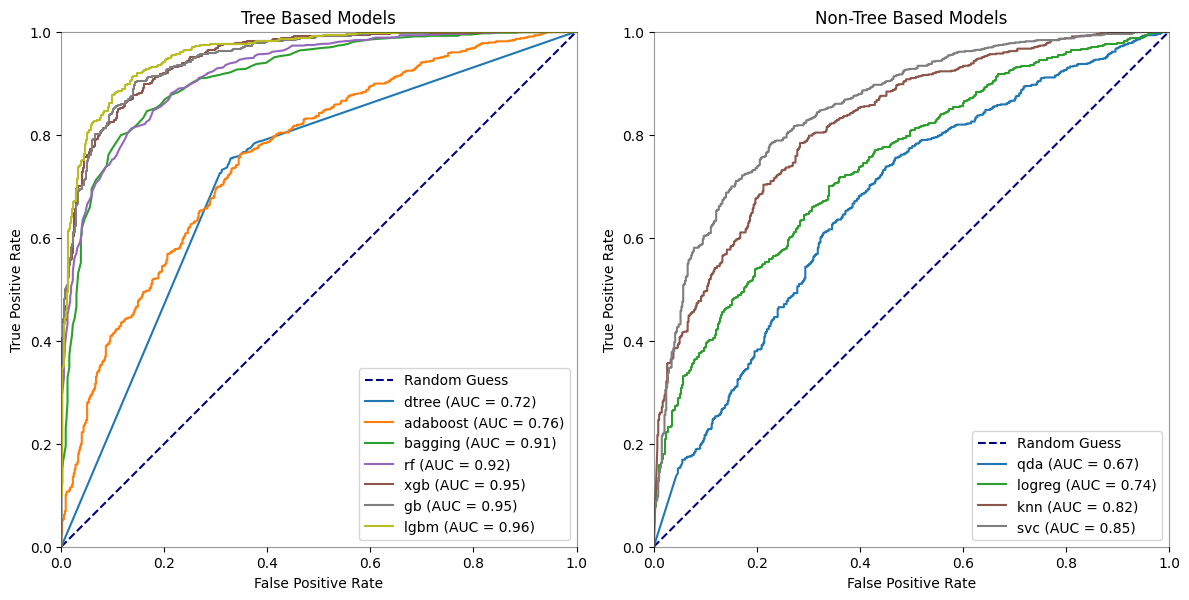

In [ ]:
results = joblib.load("evaluation_results.pkl")

# List the actual keys in your results to help with matching
print("Available model keys:", list(results.keys()))

# Update these names to match your actual model keys if needed
tree_based_models = ["dtree", "rf", "gb", "xgb", "lgbm", "adaboost", "bagging"]

# Split results
tree_based_results = {key: value for key, value in results.items() if key.lower() in tree_based_models}
non_tree_based_results = {key: value for key, value in results.items() if key.lower() not in tree_based_models}

# Plot the ROC curves
fig_combined, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
plot_roc_curves(tree_based_results, figsize=(6, 6), ax=ax1, title="Tree Based Models")
plot_roc_curves(non_tree_based_results, figsize=(6, 6), ax=ax2, title="Non-Tree Based Models")
plt.tight_layout()

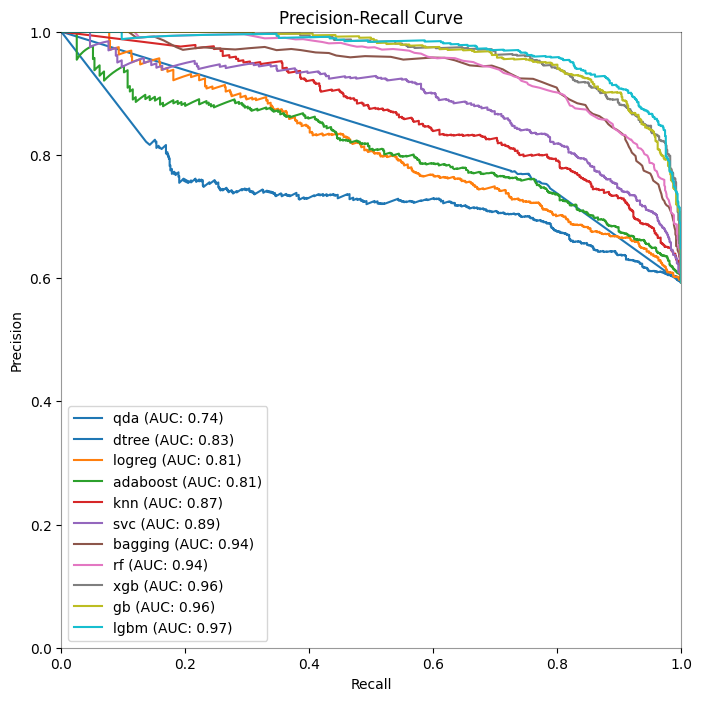

In [6]:
plot_precision_recall_curves(results,figsize=(8,8));


In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

import pandas as pd

metrics_summary = []

for model_name, model in best_estimators.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else float('nan')

    metrics_summary.append({
        "Model": model_name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "ROC_AUC": roc_auc
    })

df_metrics = pd.DataFrame(metrics_summary)
print(df_metrics)

       Model  Accuracy  Precision    Recall   ROC_AUC
0   adaboost  0.761804   0.783092  0.831169  0.831412
1    bagging  0.863284   0.855277  0.927981  0.928462
2      dtree  0.742072   0.783943  0.783943  0.738398
3         gb  0.888654   0.873239  0.951594  0.959375
4        knn  0.755462   0.787356  0.808737  0.837183
5       lgbm  0.911910   0.906532  0.950413  0.967859
6     logreg  0.704017   0.736959  0.783943  0.762386
7        qda  0.655391   0.738667  0.654073  0.703082
8         rf  0.863284   0.853738  0.930342  0.934306
9        svc  0.779422   0.802721  0.835891  0.850140
10       xgb  0.884426   0.883277  0.929162  0.957408


Confusion matrix for adaboost:


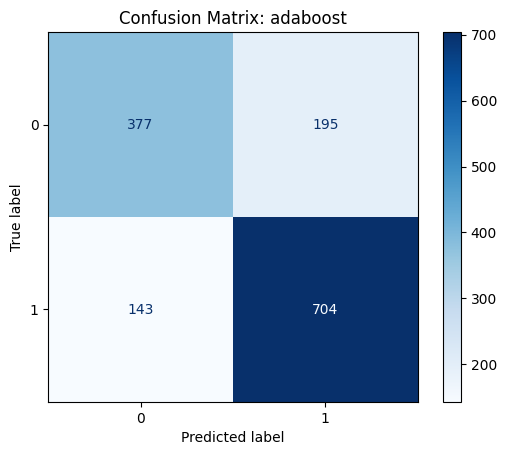

Confusion matrix for bagging:


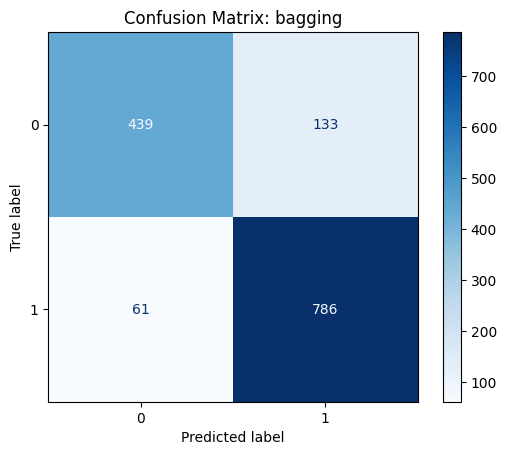

Confusion matrix for dtree:


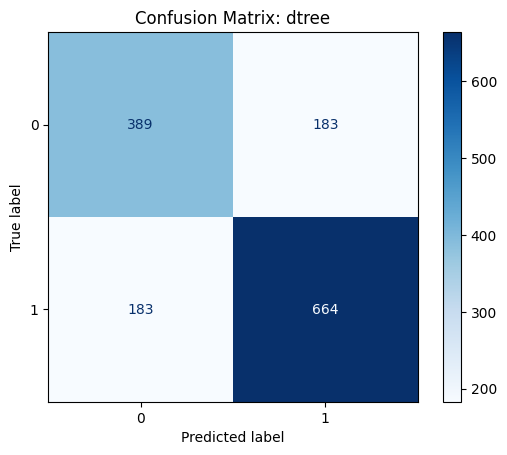

Confusion matrix for gb:


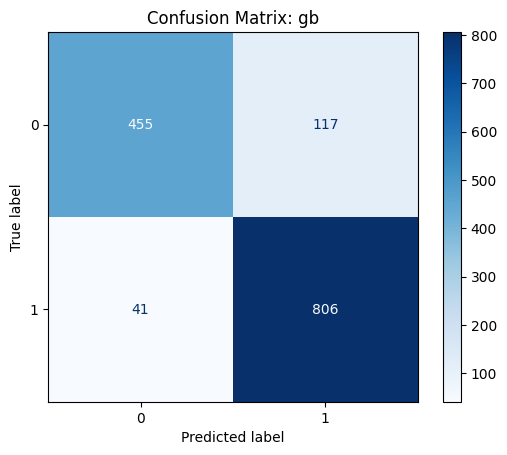

Confusion matrix for knn:


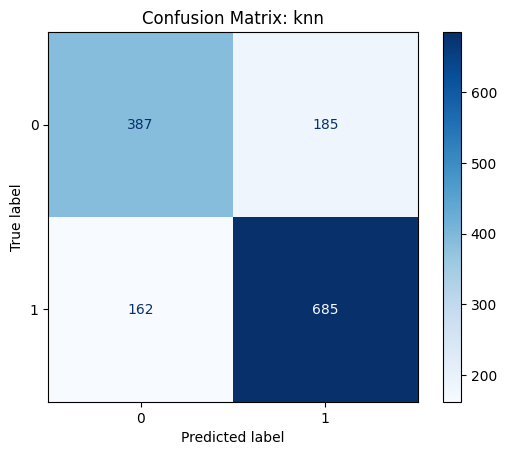

Confusion matrix for lgbm:


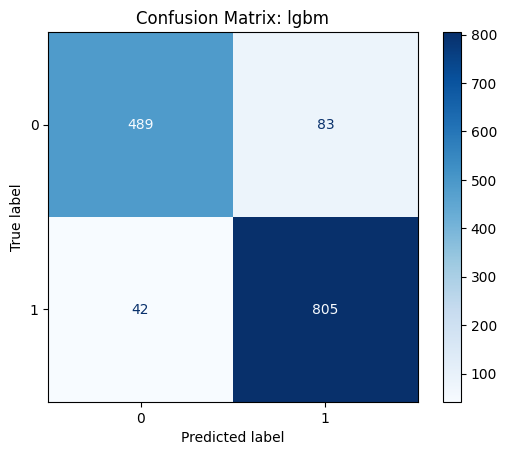

Confusion matrix for logreg:


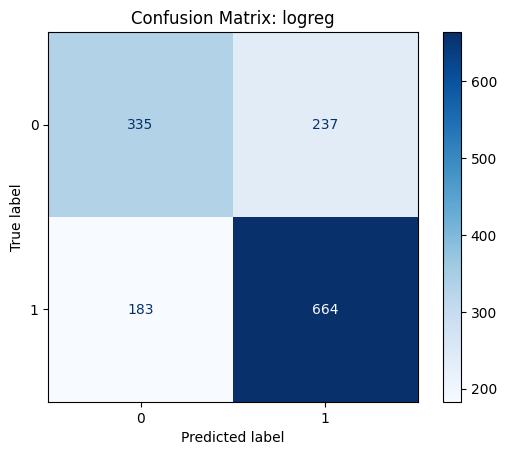

Confusion matrix for qda:


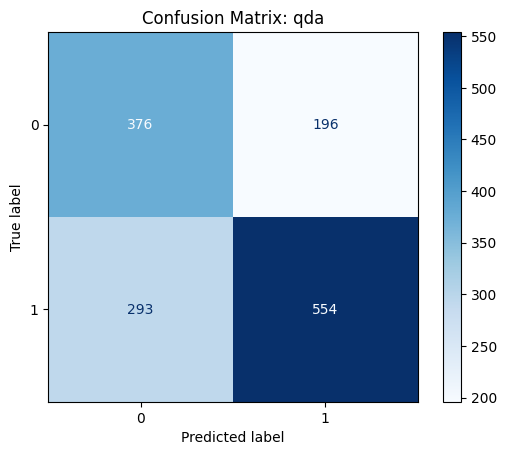

Confusion matrix for rf:


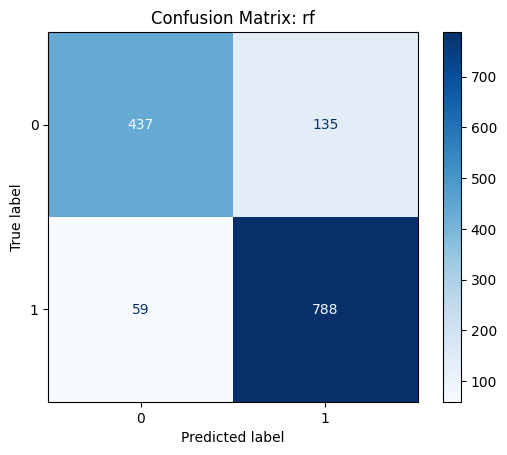

Confusion matrix for svc:


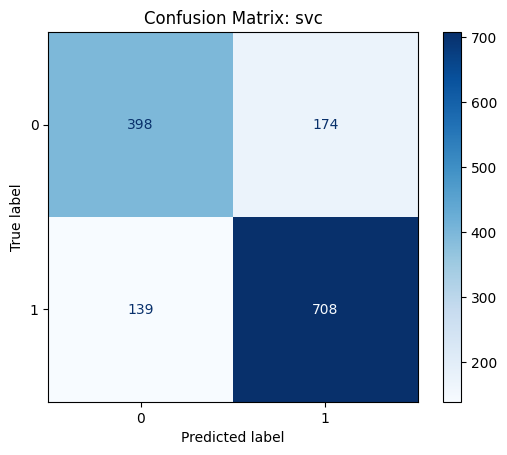

Confusion matrix for xgb:


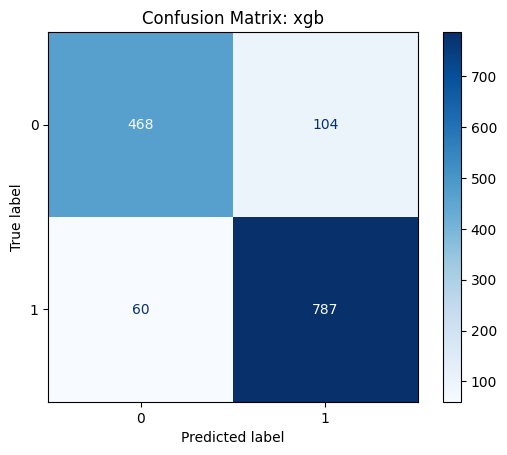

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

for model_name, model in best_estimators.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print(f"Confusion matrix for {model_name}:")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix: {model_name}")
    plt.show()

In [10]:
# Run this cell to get the actual performance scores
print("=== PERFORMANCE SUMMARY ===")
print(df_metrics.to_string(index=False))
print("\n=== TOP 3 PERFORMERS ===")
top_3 = df_metrics.nlargest(3, 'ROC_AUC')[['Model', 'Accuracy', 'Precision', 'Recall', 'ROC_AUC']]
print(top_3.to_string(index=False))

=== PERFORMANCE SUMMARY ===
   Model  Accuracy  Precision   Recall  ROC_AUC
adaboost  0.761804   0.783092 0.831169 0.831412
 bagging  0.863284   0.855277 0.927981 0.928462
   dtree  0.742072   0.783943 0.783943 0.738398
      gb  0.888654   0.873239 0.951594 0.959375
     knn  0.755462   0.787356 0.808737 0.837183
    lgbm  0.911910   0.906532 0.950413 0.967859
  logreg  0.704017   0.736959 0.783943 0.762386
     qda  0.655391   0.738667 0.654073 0.703082
      rf  0.863284   0.853738 0.930342 0.934306
     svc  0.779422   0.802721 0.835891 0.850140
     xgb  0.884426   0.883277 0.929162 0.957408

=== TOP 3 PERFORMERS ===
Model  Accuracy  Precision   Recall  ROC_AUC
 lgbm  0.911910   0.906532 0.950413 0.967859
   gb  0.888654   0.873239 0.951594 0.959375
  xgb  0.884426   0.883277 0.929162 0.957408


In [11]:
# Run this cell to get the actual performance scores
print("=== PERFORMANCE SUMMARY ===")
print(df_metrics.to_string(index=False))
print("\n=== TOP 3 PERFORMERS ===")
top_3 = df_metrics.nlargest(3, 'ROC_AUC')[['Model', 'Accuracy', 'Precision', 'Recall', 'ROC_AUC']]
print(top_3.to_string(index=False))

=== PERFORMANCE SUMMARY ===
   Model  Accuracy  Precision   Recall  ROC_AUC
adaboost  0.761804   0.783092 0.831169 0.831412
 bagging  0.863284   0.855277 0.927981 0.928462
   dtree  0.742072   0.783943 0.783943 0.738398
      gb  0.888654   0.873239 0.951594 0.959375
     knn  0.755462   0.787356 0.808737 0.837183
    lgbm  0.911910   0.906532 0.950413 0.967859
  logreg  0.704017   0.736959 0.783943 0.762386
     qda  0.655391   0.738667 0.654073 0.703082
      rf  0.863284   0.853738 0.930342 0.934306
     svc  0.779422   0.802721 0.835891 0.850140
     xgb  0.884426   0.883277 0.929162 0.957408

=== TOP 3 PERFORMERS ===
Model  Accuracy  Precision   Recall  ROC_AUC
 lgbm  0.911910   0.906532 0.950413 0.967859
   gb  0.888654   0.873239 0.951594 0.959375
  xgb  0.884426   0.883277 0.929162 0.957408


In [9]:
from sklearn.metrics import classification_report

for model_name, model in best_estimators.items():
    y_pred = model.predict(X_test)
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test, y_pred))

Classification Report for adaboost:
              precision    recall  f1-score   support

           0       0.72      0.66      0.69       572
           1       0.78      0.83      0.81       847

    accuracy                           0.76      1419
   macro avg       0.75      0.75      0.75      1419
weighted avg       0.76      0.76      0.76      1419

Classification Report for bagging:
              precision    recall  f1-score   support

           0       0.88      0.77      0.82       572
           1       0.86      0.93      0.89       847

    accuracy                           0.86      1419
   macro avg       0.87      0.85      0.85      1419
weighted avg       0.86      0.86      0.86      1419

Classification Report for dtree:
              precision    recall  f1-score   support

           0       0.68      0.68      0.68       572
           1       0.78      0.78      0.78       847

    accuracy                           0.74      1419
   macro avg       0.73 

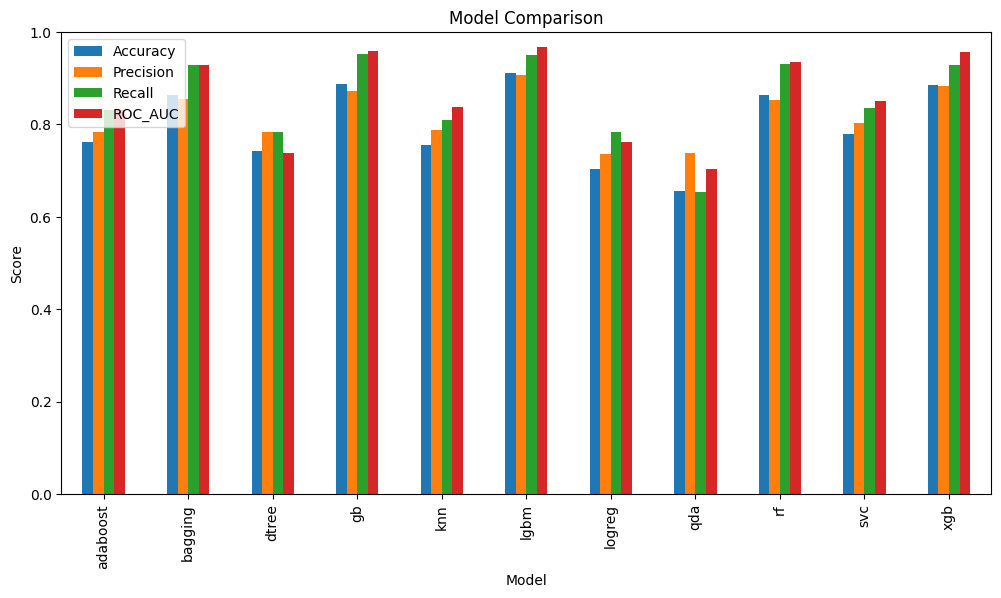

In [10]:
df_metrics.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'ROC_AUC']].plot(kind='bar', figsize=(12,6))
plt.title('Model Comparison')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()

In [11]:
# Suppose 'rf' is your best model
joblib.dump(best_estimators['rf'], 'best_rf_model.pkl')

['best_rf_model.pkl']